In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [18]:
import matplotlib.pyplot as plt

In [2]:
load_path = "/Users/sumi/_sample_pic/_kaggle/titanic"

In [3]:
train_data = pd.read_csv(load_path + "/train.csv")
test_data = pd.read_csv(load_path + "/test.csv")

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold

import lightgbm as lgb

In [7]:
# X.fillna(-1)

In [8]:
y = train_data["Survived"]
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]
categorical_features = ["Pclass", "Sex", "Cabin", "Embarked"]
# X = train_data[features]
# X = train_data[features].fillna(-1)
X = train_data[features]
for col in categorical_features:
    X[col] = X[col].astype("category")
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    891 non-null    category
 1   Sex       891 non-null    category
 2   Age       714 non-null    float64 
 3   SibSp     891 non-null    int64   
 4   Parch     891 non-null    int64   
 5   Fare      891 non-null    float64 
 6   Cabin     204 non-null    category
 7   Embarked  889 non-null    category
dtypes: category(4), float64(2), int64(2)
memory usage: 38.8 KB
None


<ipython-input-8-1453058a476c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype("category")


In [9]:
# X["Fare"].isnull().sum()

In [38]:
# K fold cross validation
scores = []
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_data):
    tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
    
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)
    
#     params = {  "objective": "binary",
#                          "seed": 71,
# #                          "verbose": 0,
#                            "verbose": 1,
# #                          "metrics": "binary_logloss"}
#                            "metrics": "binary_error"}
    params = { "objective": "binary",
                           "metrics": "binary_error"}
    num_round = 100
    
    evaluation_results = {}
    model = lgb.train(params, 
                                      lgb_train,
                                      num_boost_round=num_round,
                                      categorical_feature=categorical_features,
                                      valid_names=["train", "valid"],
                                      evals_result=evaluation_results,
                                      valid_sets=[lgb_train, lgb_eval])
    
    va_pred = model.predict(va_x)
    th = 0.5
    va_pred_binary = np.where(va_pred > th, 1, 0)
#     score_log_loss = log_loss(va_x, va_pred)
#     score_accuracy = accuracy_score(va_y, va_pred)
    score_accuracy = accuracy_score(va_y, va_pred_binary)
    scores.append(score_accuracy)

print("mean score : ", np.mean(scores))

[LightGBM] [Info] Number of positive: 266, number of negative: 402
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398204 -> initscore=-0.412956
[LightGBM] [Info] Start training from score -0.412956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's binary_error: 0.398204	valid's binary_error: 0.340807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's binary_error: 0.291916	valid's binary_error: 0.233184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's binary_error: 0.199102	valid's binary_error: 0.156951
[LightGBM] [Warning] No 

[LightGBM] [Info] Number of positive: 256, number of negative: 412
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383234 -> initscore=-0.475846
[LightGBM] [Info] Start training from score -0.475846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's binary_error: 0.383234	valid's binary_error: 0.38565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's binary_error: 0.300898	valid's binary_error: 0.340807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's binary_error: 0.211078	valid's binary_error: 0.219731
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	train's binary_error: 0.0434132	valid's binary_error: 0.179372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	train's binary_error: 0.0449102	valid's binary_error: 0.179372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	train's binary_error: 0.0434132	valid's binary_error: 0.179372
[LightGBM] [Info] Number of positive: 253, number of negative: 415
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378743 -> initscore=-0.494889
[LightGBM] [Info] Start training from score -0.494889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	tr

[LightGBM] [Info] Number of positive: 251, number of negative: 418
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 669, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375187 -> initscore=-0.510028
[LightGBM] [Info] Start training from score -0.510028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's binary_error: 0.375187	valid's binary_error: 0.40991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's binary_error: 0.375187	valid's binary_error: 0.40991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's binary_error: 0.206278	valid's binary_error: 0.234234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	train's bin

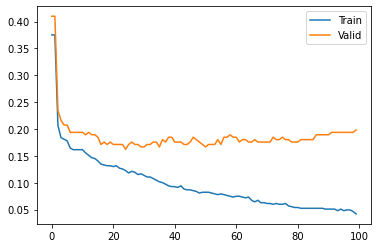

In [39]:
plt.plot(evaluation_results["train"]["binary_error"], label='Train')
plt.plot(evaluation_results["valid"]["binary_error"], label='Valid')
plt.legend()

In [11]:
# X.info()
# X["Fare"].max()
# X["Fare"].min()

In [40]:
lgb_train = lgb.Dataset(X, y)

# seed = 71
seed = 101
# params = {  "objective": "binary",
#                      "seed": seed,
#                      "verbose": 0,
# #                      "metrics": "binary_logloss"}
#                        "metrics": "binary_error"}
params = {  "objective": "binary",
                       "metrics": "binary_error"}
num_round = 100

model = lgb.train(params, 
                                  lgb_train,
                                  num_boost_round=num_round,
                                  categorical_feature=categorical_features)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


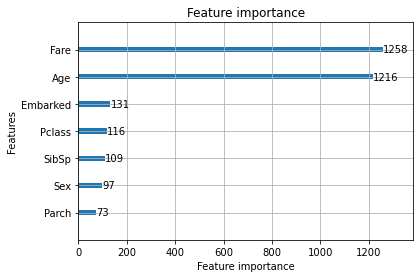

In [41]:
# model.feature_importance()
lgb.plot_importance(model)

In [42]:
X_test = test_data[features]
for col in categorical_features:
    X_test[col] = X_test[col].astype("category")
    
y_test = model.predict(X_test)

<ipython-input-42-dc3317fe8418>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype("category")


In [43]:
y_test_binary = np.where(y_test  > 0.5, 1, 0)

In [44]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_test_binary})
output.to_csv('my_submission_lightgbm.csv', index=False)